In [1]:
# загружаем необходимые библиотеки, классы и функции
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     cross_validate)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from rfpimp import (feature_dependence_matrix, 
                    plot_dependence_heatmap, 
                    plot_corr_heatmap)
import shap
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be impor

In [2]:
# отключаем экспоненциальное представление и увеличиваем
# максимальное количество отображаемых столбцов
pd.set_option('display.float_format', lambda x: '%.8f' % x)
pd.set_option('display.max_columns', 60)

In [3]:
# загружаем данные
data = pd.read_csv('Data/porto_seguro_train.csv')
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.70000000,0.20000000,0.71807033,10,1,-1,0,1,4,1,0,0,1,12,2,0.40000000,0.88367892,0.37080992,3.60555128,0.60000000,0.50000000,0.20000000,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.80000000,0.40000000,0.76607767,11,1,-1,0,-1,11,1,1,2,1,19,3,0.31622777,0.61881652,0.38871583,2.44948974,0.30000000,0.10000000,0.30000000,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.00000000,0.00000000,-1.00000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.31622777,0.64158572,0.34727511,3.31662479,0.50000000,0.70000000,0.10000000,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.90000000,0.20000000,0.58094750,7,1,0,0,1,11,1,1,3,1,104,1,0.37416574,0.54294879,0.29495762,2.00000000,0.60000000,0.90000000,0.10000000,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.70000000,0.60000000,0.84075859,11,1,-1,0,-1,14,1,1,2,1,82,3,0.31606961,0.56583150,0.36510273,2.00000000,0.40000000,0.60000000,0.00000000,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
# удаляем id
data.drop('id', axis=1, inplace=True)

In [5]:
# смотрим пропуски и типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_

In [6]:
# разбиваем данные на обучающие и тестовые: получаем обучающий
# массив признаков, тестовый массив признаков, обучающий массив
# меток, тестовый массив меток
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target', axis=1), 
    data['target'], 
    test_size=0.3,
    stratify=data['target'],
    random_state=42)

In [7]:
# создаем экземляр класса LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42, 
                            n_estimators=300)

# задаем сетку гиперпараметров
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1]
}

# создаем экземпляр класса GridSearchCV, передав
# конвейер, сетку гиперпараметров и указав
# количество блоков перекрестной проверки
gs = GridSearchCV(lgbm_model, 
                  param_grid,
                  scoring='roc_auc',
                  cv=5)

# выполняем поиск по всем значениям сетки
gs.fit(X_train, y_train);

In [8]:
# смотрим наилучшие значения гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format(
    gs.best_params_))
# смотрим наилучшее значение AUC
print("Наилучшее значение AUC: {:.3f}".format(
    gs.best_score_))

Наилучшие значения гиперпараметров: {'learning_rate': 0.01}
Наилучшее значение AUC: 0.633


In [9]:
# создаем экземляр класса LGBMClassifier
lgbm_model2 = LGBMClassifier(random_state=42, 
                             n_estimators=300, 
                             learning_rate=0.01)

# задаем сетку гиперпараметров
param_grid2 = {
    'lambda_l1': [0, 10],
    'bagging_fraction': [0.5, 1],
    'feature_fraction': [0.5, 1]
}

# создаем экземпляр класса GridSearchCV, передав
# конвейер, сетку гиперпараметров и указав
# количество блоков перекрестной проверки
gs2 = GridSearchCV(lgbm_model2, 
                   param_grid2,
                   scoring='roc_auc',
                   cv=5)

# выполняем поиск по всем значениям сетки
gs2.fit(X_train, y_train);

In [10]:
# смотрим наилучшие значения гиперпараметров
print('Наилучшие значения гиперпараметров: {}'.format(
    gs2.best_params_))
# смотрим наилучшее значение AUC
print('Наилучшее значение AUC: {:.3f}'.format(
    gs2.best_score_))

Наилучшие значения гиперпараметров: {'bagging_fraction': 0.5, 'feature_fraction': 1, 'lambda_l1': 10}
Наилучшее значение AUC: 0.634


In [11]:
# создаем экземляр класса LGBMClassifier
model_all_features = LGBMClassifier(
    random_state=42, learning_rate=0.01, 
    n_estimators=300, bagging_fraction=0.5, 
    feature_fraction=1, lambda_l1=10,
    importance_type='gain')

# выполняем перекрестную проверку и сохраняем результат 
# с помощью функции cross_validate()
output = cross_validate(
    model_all_features, X_train, y_train, cv=5, 
    scoring='roc_auc', return_estimator=True)

# создаем список fi, в который будем сохранять 
# важности признаков, и сохраняем в него важности, 
# рассчитанные для каждой из моделей
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором 
# будут именами наших переменных
fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx) 
             for idx in range(len(fi))],
    index=X_train.columns)
# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# смотрим полученный датафрейм
fi

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
ps_ind_01,3634.11843014,3172.45801353,4035.87575197,3279.06987143,2702.83714104,3364.87184162
ps_ind_02_cat,1180.81135607,1882.19693899,1775.92964697,2375.23713636,2278.47166729,1898.52934914
ps_ind_03,13521.97072601,12791.99010944,11509.53043318,11959.67374229,12108.93555784,12378.42011375
ps_ind_04_cat,1130.56435776,1201.73512697,1314.90494204,904.47342062,798.09325933,1069.95422134
ps_ind_05_cat,16222.12306643,16123.02086258,15932.37066174,16057.97703266,17996.74093056,16466.44651079
ps_ind_06_bin,7848.01708078,7344.12867975,7628.59964228,6914.00448751,8448.97758007,7636.74549408
ps_ind_07_bin,1684.69169283,2116.86437941,1721.08208227,1947.20034266,1518.87499571,1797.74269857
ps_ind_08_bin,797.62602758,294.66852856,602.52638626,445.62016964,395.38190889,507.16460419
ps_ind_09_bin,2757.77236462,2649.19727755,2396.16355896,2329.34756851,3267.23337460,2679.94282885
ps_ind_10_bin,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [12]:
# записываем серию, в которой индексные метки - признаки,
# значения - важности
features = fi['mean_importance']
# сортируем индексные метки по возрастанию важностей
features = features.sort_values(ascending=True)
features

ps_calc_16_bin       0.00000000
ps_car_10_cat        0.00000000
ps_ind_13_bin        0.00000000
ps_ind_12_bin        0.00000000
ps_ind_10_bin        0.00000000
ps_ind_11_bin        0.00000000
ps_ind_14            4.13852005
ps_calc_18_bin      26.88713598
ps_calc_20_bin      27.24685402
ps_calc_19_bin      29.30425615
ps_calc_15_bin      29.94704609
ps_car_08_cat       40.85762415
ps_calc_17_bin      43.58873396
ps_ind_18_bin       87.11542606
ps_calc_06         287.05552168
ps_calc_07         290.63048229
ps_calc_08         305.89214191
ps_calc_04         316.40283184
ps_calc_13         317.46883774
ps_calc_12         390.33250446
ps_calc_11         397.19356203
ps_car_05_cat      418.74798470
ps_calc_05         471.20317659
ps_calc_09         495.92781897
ps_ind_08_bin      507.16460419
ps_calc_02         532.49589968
ps_car_12          637.38455076
ps_calc_01         648.48987713
ps_calc_03         702.67045021
ps_car_02_cat      713.74446478
ps_car_06_cat      716.96568480
ps_calc_

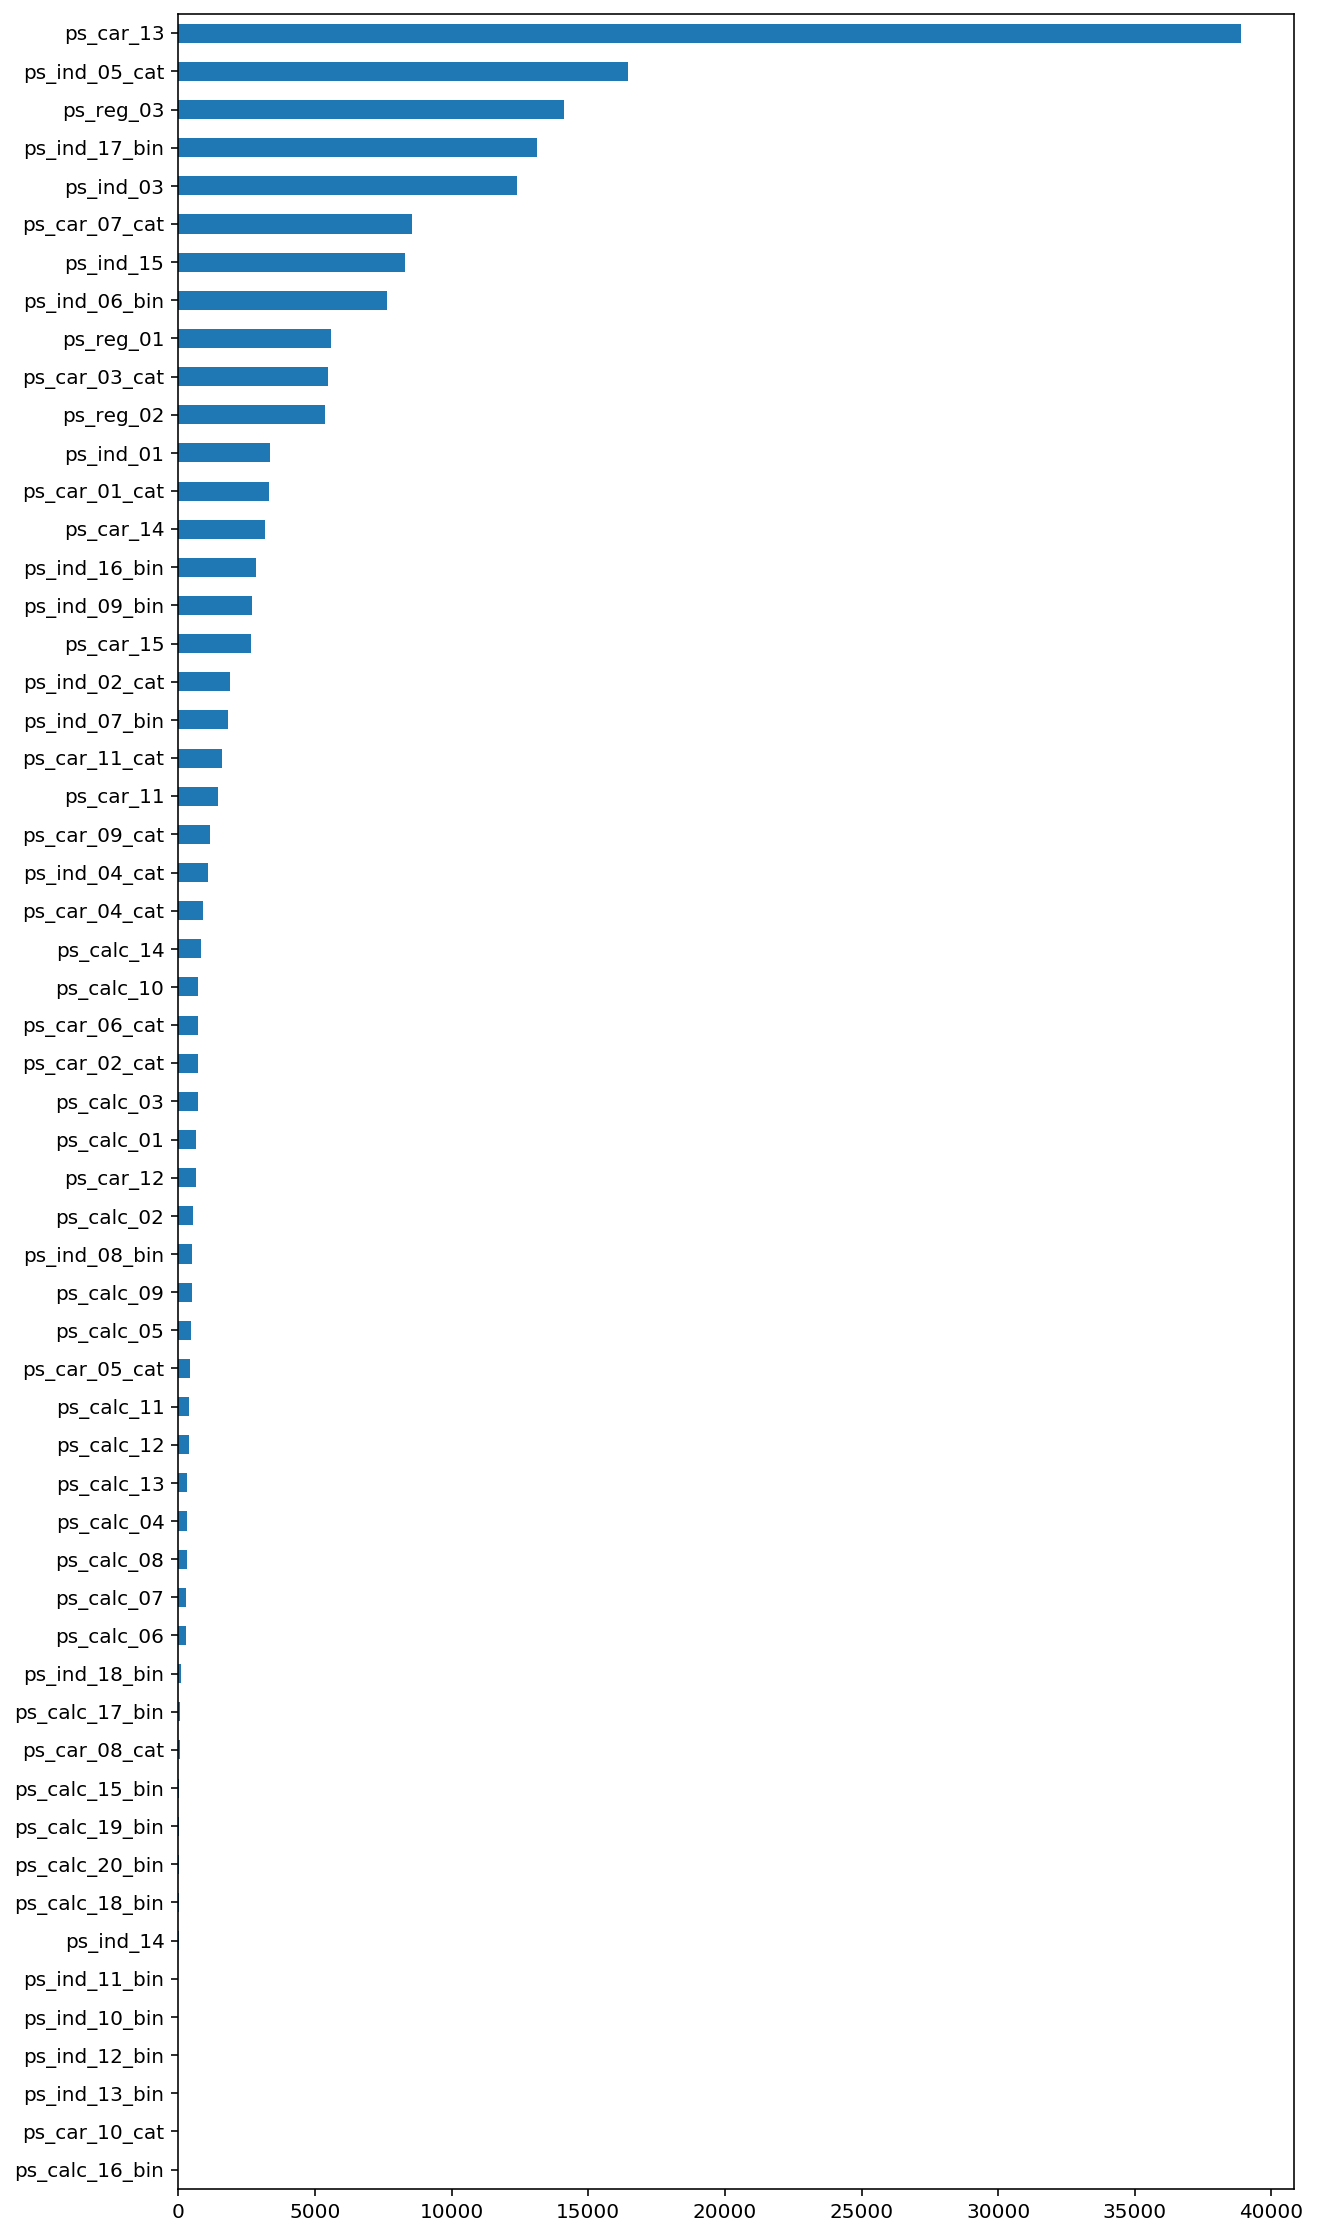

In [13]:
# выводим график усредненных важностей
features.plot.barh(figsize=(10, 20));

In [14]:
# создаем список признаков
features = list(features.index)
features

['ps_calc_16_bin',
 'ps_car_10_cat',
 'ps_ind_13_bin',
 'ps_ind_12_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_14',
 'ps_calc_18_bin',
 'ps_calc_20_bin',
 'ps_calc_19_bin',
 'ps_calc_15_bin',
 'ps_car_08_cat',
 'ps_calc_17_bin',
 'ps_ind_18_bin',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_04',
 'ps_calc_13',
 'ps_calc_12',
 'ps_calc_11',
 'ps_car_05_cat',
 'ps_calc_05',
 'ps_calc_09',
 'ps_ind_08_bin',
 'ps_calc_02',
 'ps_car_12',
 'ps_calc_01',
 'ps_calc_03',
 'ps_car_02_cat',
 'ps_car_06_cat',
 'ps_calc_10',
 'ps_calc_14',
 'ps_car_04_cat',
 'ps_ind_04_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_11_cat',
 'ps_ind_07_bin',
 'ps_ind_02_cat',
 'ps_car_15',
 'ps_ind_09_bin',
 'ps_ind_16_bin',
 'ps_car_14',
 'ps_car_01_cat',
 'ps_ind_01',
 'ps_reg_02',
 'ps_car_03_cat',
 'ps_reg_01',
 'ps_ind_06_bin',
 'ps_ind_15',
 'ps_car_07_cat',
 'ps_ind_03',
 'ps_ind_17_bin',
 'ps_reg_03',
 'ps_ind_05_cat',
 'ps_car_13']

In [15]:
# вычисляем оценку AUC-ROC, усредненную по 5 проверочным 
# блокам перекрестной проверки (5 моделям со всеми 
# признаками)
auc_score_all = output['test_score'].mean()
auc_score_all

0.6337963788722549

In [16]:
# задаем пороговое значение разницы AUC
tol = 0.0001

print("выполнение последовательного удаления признаков")

# создаем список, в который будем 
# записывать удаляемые признаки
features_to_remove = []
# создаем список, в который будем 
# записывать значение AUC
auc_score_mean_list = []
# создаем список, в который будем 
# записывать разницу AUC
diff_auc_list = []

# задаем счетчик для оценки прогресса
count = 1

# итерируем по всем признакам, признаки упорядочены по
# возрастанию важности на основе информационного выигрыша
for feature in features:
    print()
    print("проверяемый признак: ", feature, " признак ", count,
          " из ", len(features))
    count = count + 1

    # создаем экземляр класса LGBMClassifier
    model = LGBMClassifier(
        random_state=42, learning_rate=0.01, 
        n_estimators=300, bagging_fraction=0.5, 
        feature_fraction=1, lambda_l1=10)

    # обучаем модели со всеми признаками минус уже удаленные признаки 
    # (берем их из списка удаляемых признаков) и оцениваемый признак
    auc_scores = cross_val_score(
        model, 
        X_train.drop(features_to_remove + [feature], axis=1), 
        y_train, 
        scoring='roc_auc', 
        cv=5)
    
    # вычисляем AUC, усредненный по проверочным блокам
    # перекрестной проверки
    auc_score_mean = auc_scores.mean()
    
    # печатаем усредненное значение AUC
    print("AUC модели после удаления={}".format((auc_score_mean)))
    
    # добавляем усредненное значение AUC в список
    auc_score_mean_list.append(auc_score_mean)

    # печатаем AUC модели со всеми признаками
    # (опорное значение AUC)
    print("AUC модели со всеми признаками={}".format((auc_score_all)))

    # определяем разницу AUC (если отрицательное значение 
    # - удаление признака улучшило AUC)
    diff_auc = auc_score_all - auc_score_mean
    
    # записываем разницу AUC в список
    diff_auc_list.append(diff_auc)

    # сравниваем разницу AUC с порогом, заданным заранее
    # если разница AUC больше или равна порогу, сохраняем
    if diff_auc >= tol:
        print("Разница AUC={}".format(diff_auc))
        print("сохраняем: ", feature)
        print
    
    # если разница AUC меньше порога, удаляем
    else:
        print("Разница AUC={}".format(diff_auc))
        print("удаляем: ", feature)
        print
        
        # если разница AUC меньше порога и мы удаляем признак,
        # мы в качестве нового опорного значения AUC задаем
        # значение AUC для модели с оставшимися признаками
        auc_score_all = auc_score_mean
        
        # добавляем удаляемый признак в список
        features_to_remove.append(feature)

# формируем датафрейм
df = pd.DataFrame({'feature': features, 
                   'auc_score_mean': auc_score_mean_list,
                   'diff_auc_score': diff_auc_list})        

# цикл завершен, вычисляем количество 
# удаленных признаков
print("ВЫПОЛНЕНО!!")
print("общее количество признаков для удаления: ", 
      len(features_to_remove))

# определяем признаки, которые мы хотим сохранить (не удаляем)
features_to_keep = [x for x in features 
                    if x not in features_to_remove]
print("общее количество признаков для сохранения: ", 
      len(features_to_keep))

выполнение последовательного удаления признаков

проверяемый признак:  ps_calc_16_bin  признак  1  из  57
AUC модели после удаления=0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
Разница AUC=0.0
удаляем:  ps_calc_16_bin

проверяемый признак:  ps_car_10_cat  признак  2  из  57
AUC модели после удаления=0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
Разница AUC=0.0
удаляем:  ps_car_10_cat

проверяемый признак:  ps_ind_13_bin  признак  3  из  57
AUC модели после удаления=0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
Разница AUC=0.0
удаляем:  ps_ind_13_bin

проверяемый признак:  ps_ind_12_bin  признак  4  из  57
AUC модели после удаления=0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
Разница AUC=0.0
удаляем:  ps_ind_12_bin

проверяемый признак:  ps_ind_10_bin  признак  5  из  57
AUC модели после удаления=0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
Разница AUC=0.0
удаляем:  ps_i

AUC модели после удаления=0.6344218813602556
AUC модели со всеми признаками=0.6346424061516865
Разница AUC=0.00022052479143097603
сохраняем:  ps_car_15

проверяемый признак:  ps_ind_09_bin  признак  42  из  57
AUC модели после удаления=0.6343011794451577
AUC модели со всеми признаками=0.6346424061516865
Разница AUC=0.0003412267065288077
сохраняем:  ps_ind_09_bin

проверяемый признак:  ps_ind_16_bin  признак  43  из  57
AUC модели после удаления=0.6345460553627644
AUC модели со всеми признаками=0.6346424061516865
Разница AUC=9.635078892211713e-05
удаляем:  ps_ind_16_bin

проверяемый признак:  ps_car_14  признак  44  из  57
AUC модели после удаления=0.6346202490095839
AUC модели со всеми признаками=0.6345460553627644
Разница AUC=-7.419364681948704e-05
удаляем:  ps_car_14

проверяемый признак:  ps_car_01_cat  признак  45  из  57
AUC модели после удаления=0.6339253221942721
AUC модели со всеми признаками=0.6346202490095839
Разница AUC=0.0006949268153118027
сохраняем:  ps_car_01_cat

провер

In [17]:
# выводим получившийся датафрейм
df.sort_values(by='diff_auc_score', ascending=False)

,feature,auc_score_mean,diff_auc_score
55,ps_ind_05_cat,0.62978115,0.00491098
52,ps_ind_03,0.63029787,0.00439426
56,ps_car_13,0.63193996,0.00275216
53,ps_ind_17_bin,0.63213864,0.00255348
50,ps_ind_15,0.63253407,0.00215805
51,ps_car_07_cat,0.63291583,0.00177629
48,ps_reg_01,0.63336871,0.00125154
45,ps_ind_01,0.63378883,0.00083142
44,ps_car_01_cat,0.63392532,0.00069493
47,ps_car_03_cat,0.63395877,0.00066147


In [18]:
# еще один подход - смотрим, как меняются важности
# признаков по мере увеличения глубины: наиболее
# важные признаки - те, которые начинают
# использоваться раньше остальных

# задаем сетку значений глубины
max_depth_grid = [1, 2, 3, 4, 5]

# создаем список fi, в который будем сохранять 
# важности признаков, и сохраняем в него важности, 
# рассчитанные для каждой из моделей
fi = []

# обучаем модели с разными значениями глубины, получаем
# важности и записываем важности в список
for max_depth in max_depth_grid:
    model_all_features = LGBMClassifier(
        random_state=42, 
        learning_rate=0.01, 
        n_estimators=300,
        bagging_fraction=0.5, 
        feature_fraction=1, 
        lambda_l1=10,
        max_depth=max_depth,
        importance_type='gain')
    model_all_features.fit(X_train, y_train)
    fi.append(model_all_features.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором 
# будут именами наших переменных
fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx) 
             for idx in range(len(fi))],
    index=X_train.columns)

# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# сортируем по убыванию усредненных важностей
fi = fi.sort_values(by='mean_importance', ascending=False)
# смотрим полученный датафрейм
fi

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
ps_car_13,31088.76501465,37646.84114456,41829.26031256,43967.54304695,46634.65979491,40233.41386273
ps_ind_05_cat,11652.49598694,17385.41012573,19248.93219471,19829.36675119,20479.29731715,17719.10047514
ps_ind_17_bin,13619.29296875,16078.80482960,15924.80874634,16155.20823884,16395.42095292,15634.70714729
ps_reg_03,10162.90495300,12752.14356613,14365.13713789,14954.14613691,15789.47207206,13604.76077320
ps_car_07_cat,7655.76197815,9674.39733505,10612.05427265,10625.81039953,10304.01973176,9774.40874343
ps_ind_06_bin,6724.82598877,8012.71405029,8784.96511269,8746.07821178,10020.12641358,8457.74195542
ps_ind_03,831.29901123,5254.63282585,9482.69581079,11901.62035066,13185.44850903,8131.13930151
ps_car_03_cat,2305.92500305,5675.29155350,6248.71047497,6779.32622671,6998.71988058,5601.59462776
ps_ind_15,0.00000000,3759.04252434,5811.22193480,7761.13614535,8936.56874725,5253.59387035
ps_reg_02,2386.90000916,4291.70919228,4320.85382652,5384.68808004,6524.61982181,4581.75418596


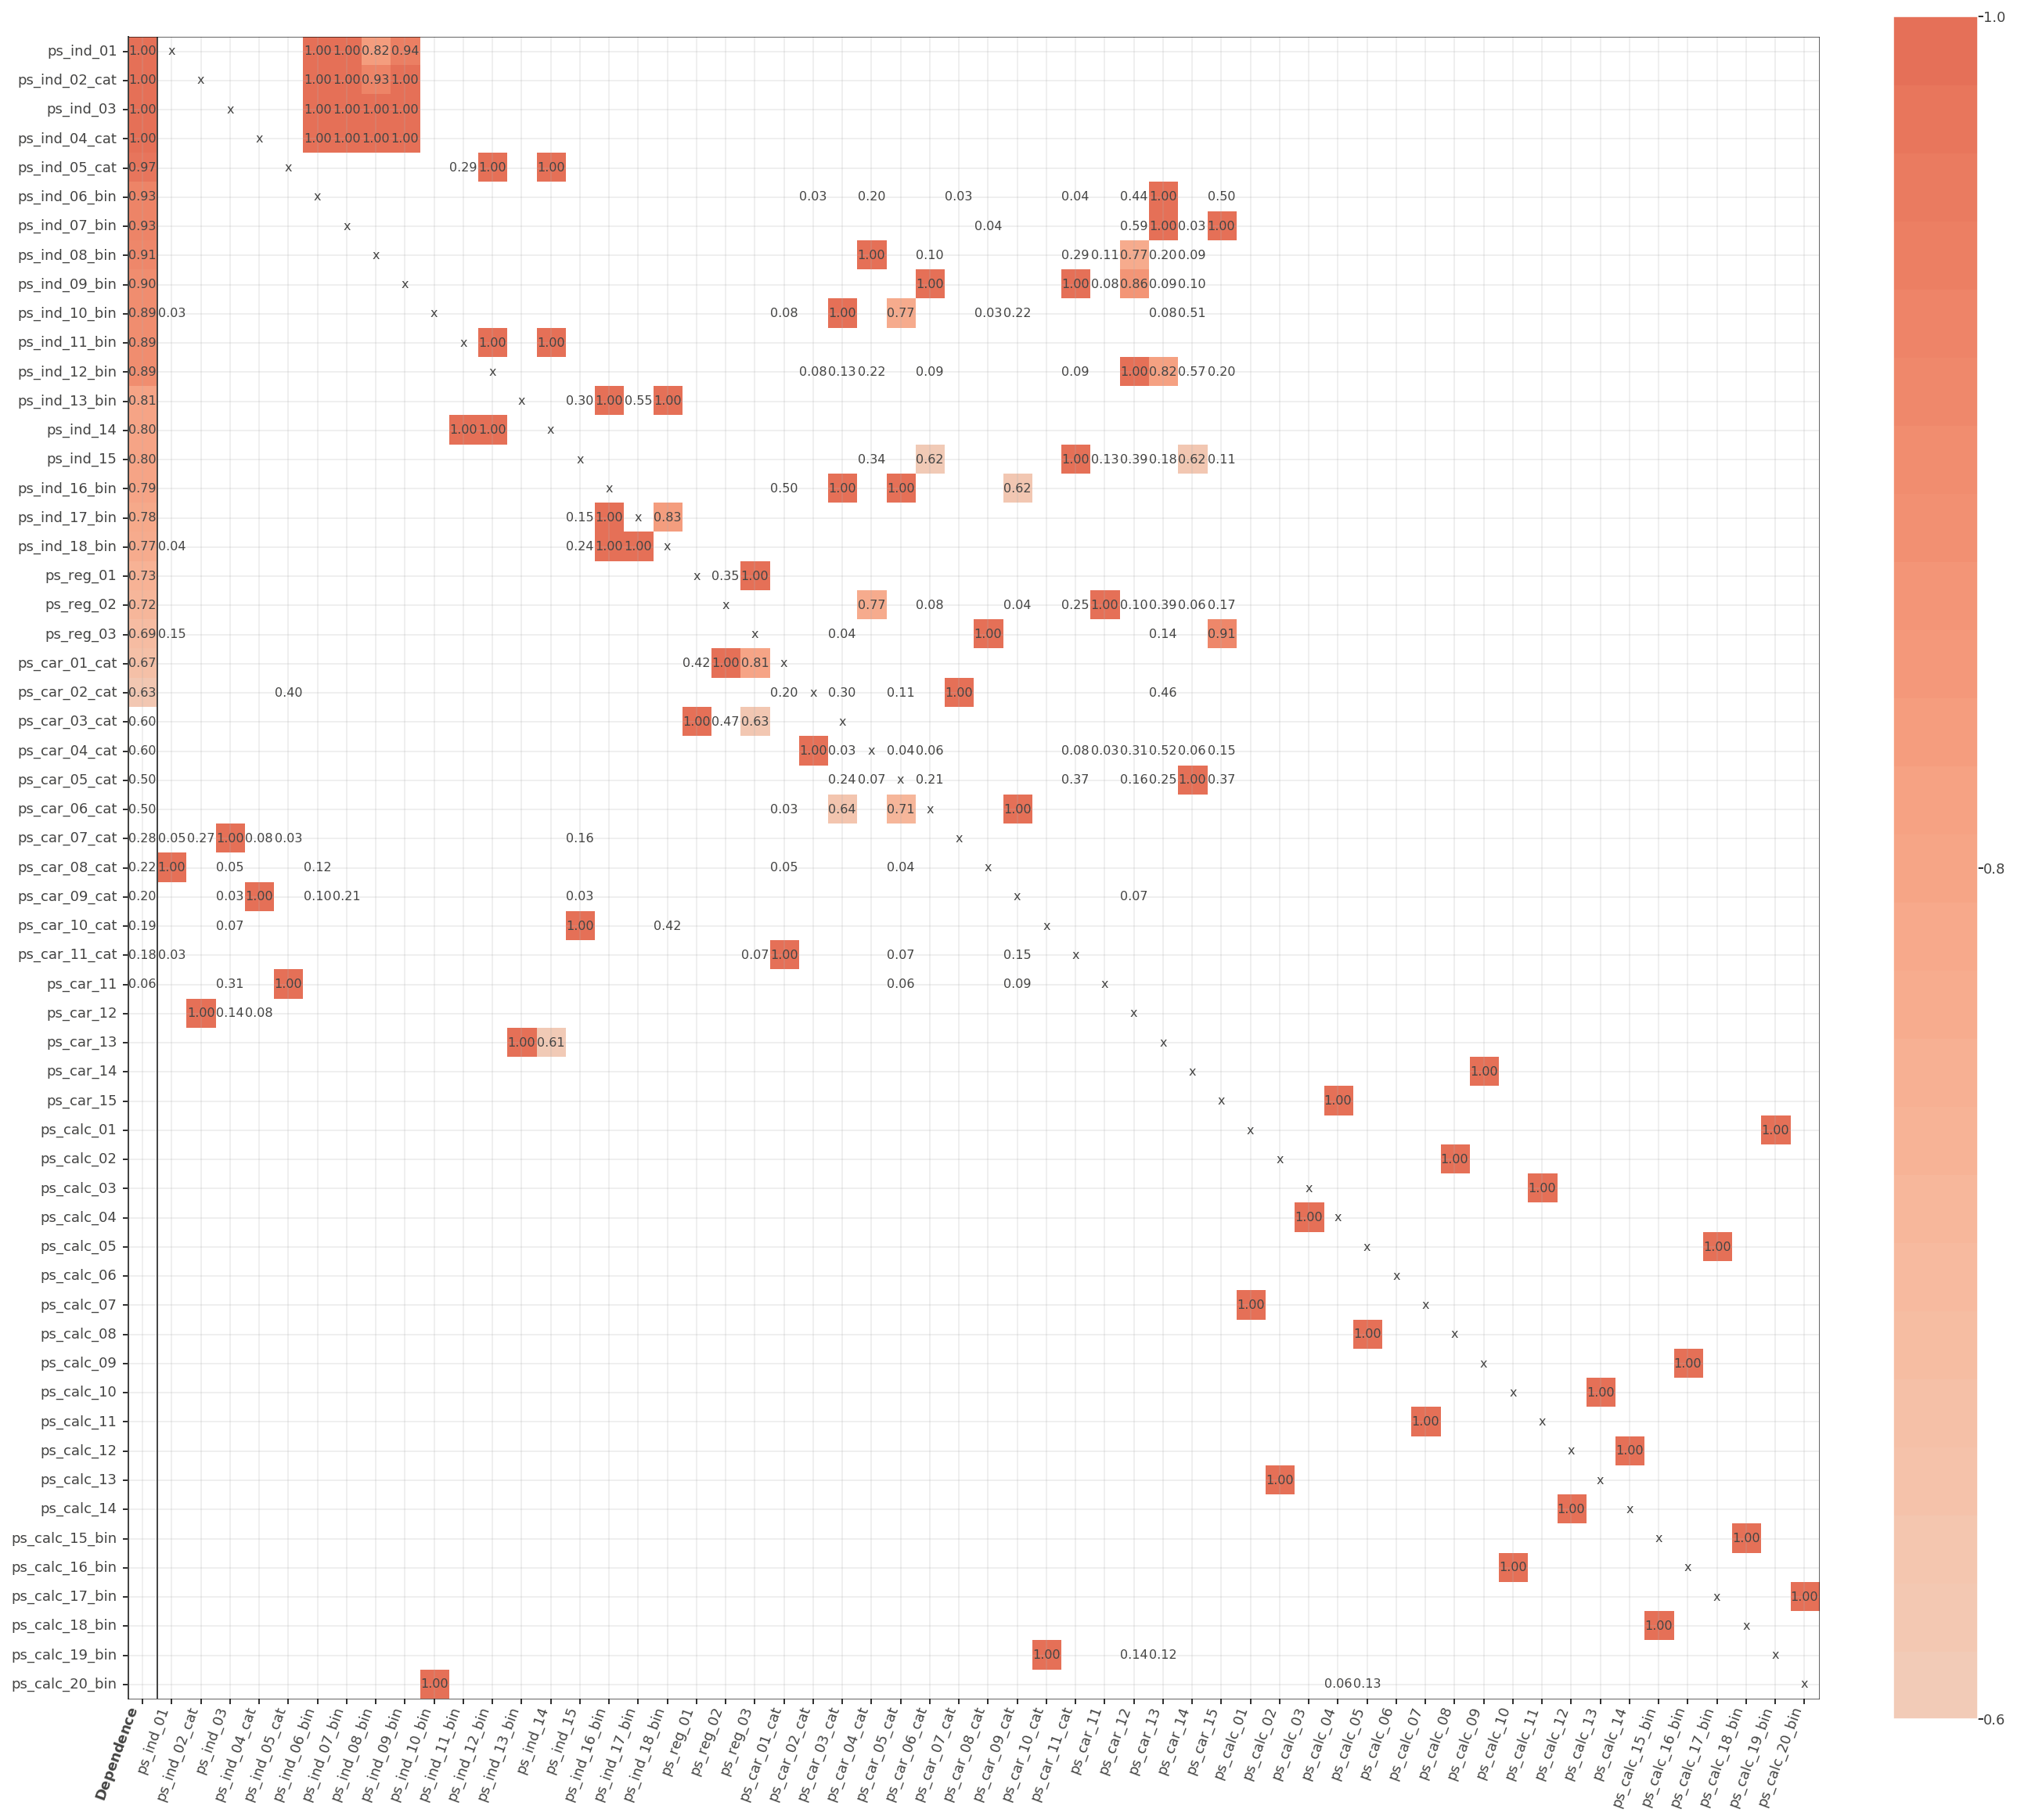

In [19]:
# вычисляем матрицу зависимостей признаков, значения - это 
# пермутированные важности признаков, с помощью которых
# мы пытаемся предсказать интересующий признак
D = feature_dependence_matrix(X_train, sort_by_dependence=True)
viz = plot_dependence_heatmap(D, figsize=(18, 18))
viz.view()

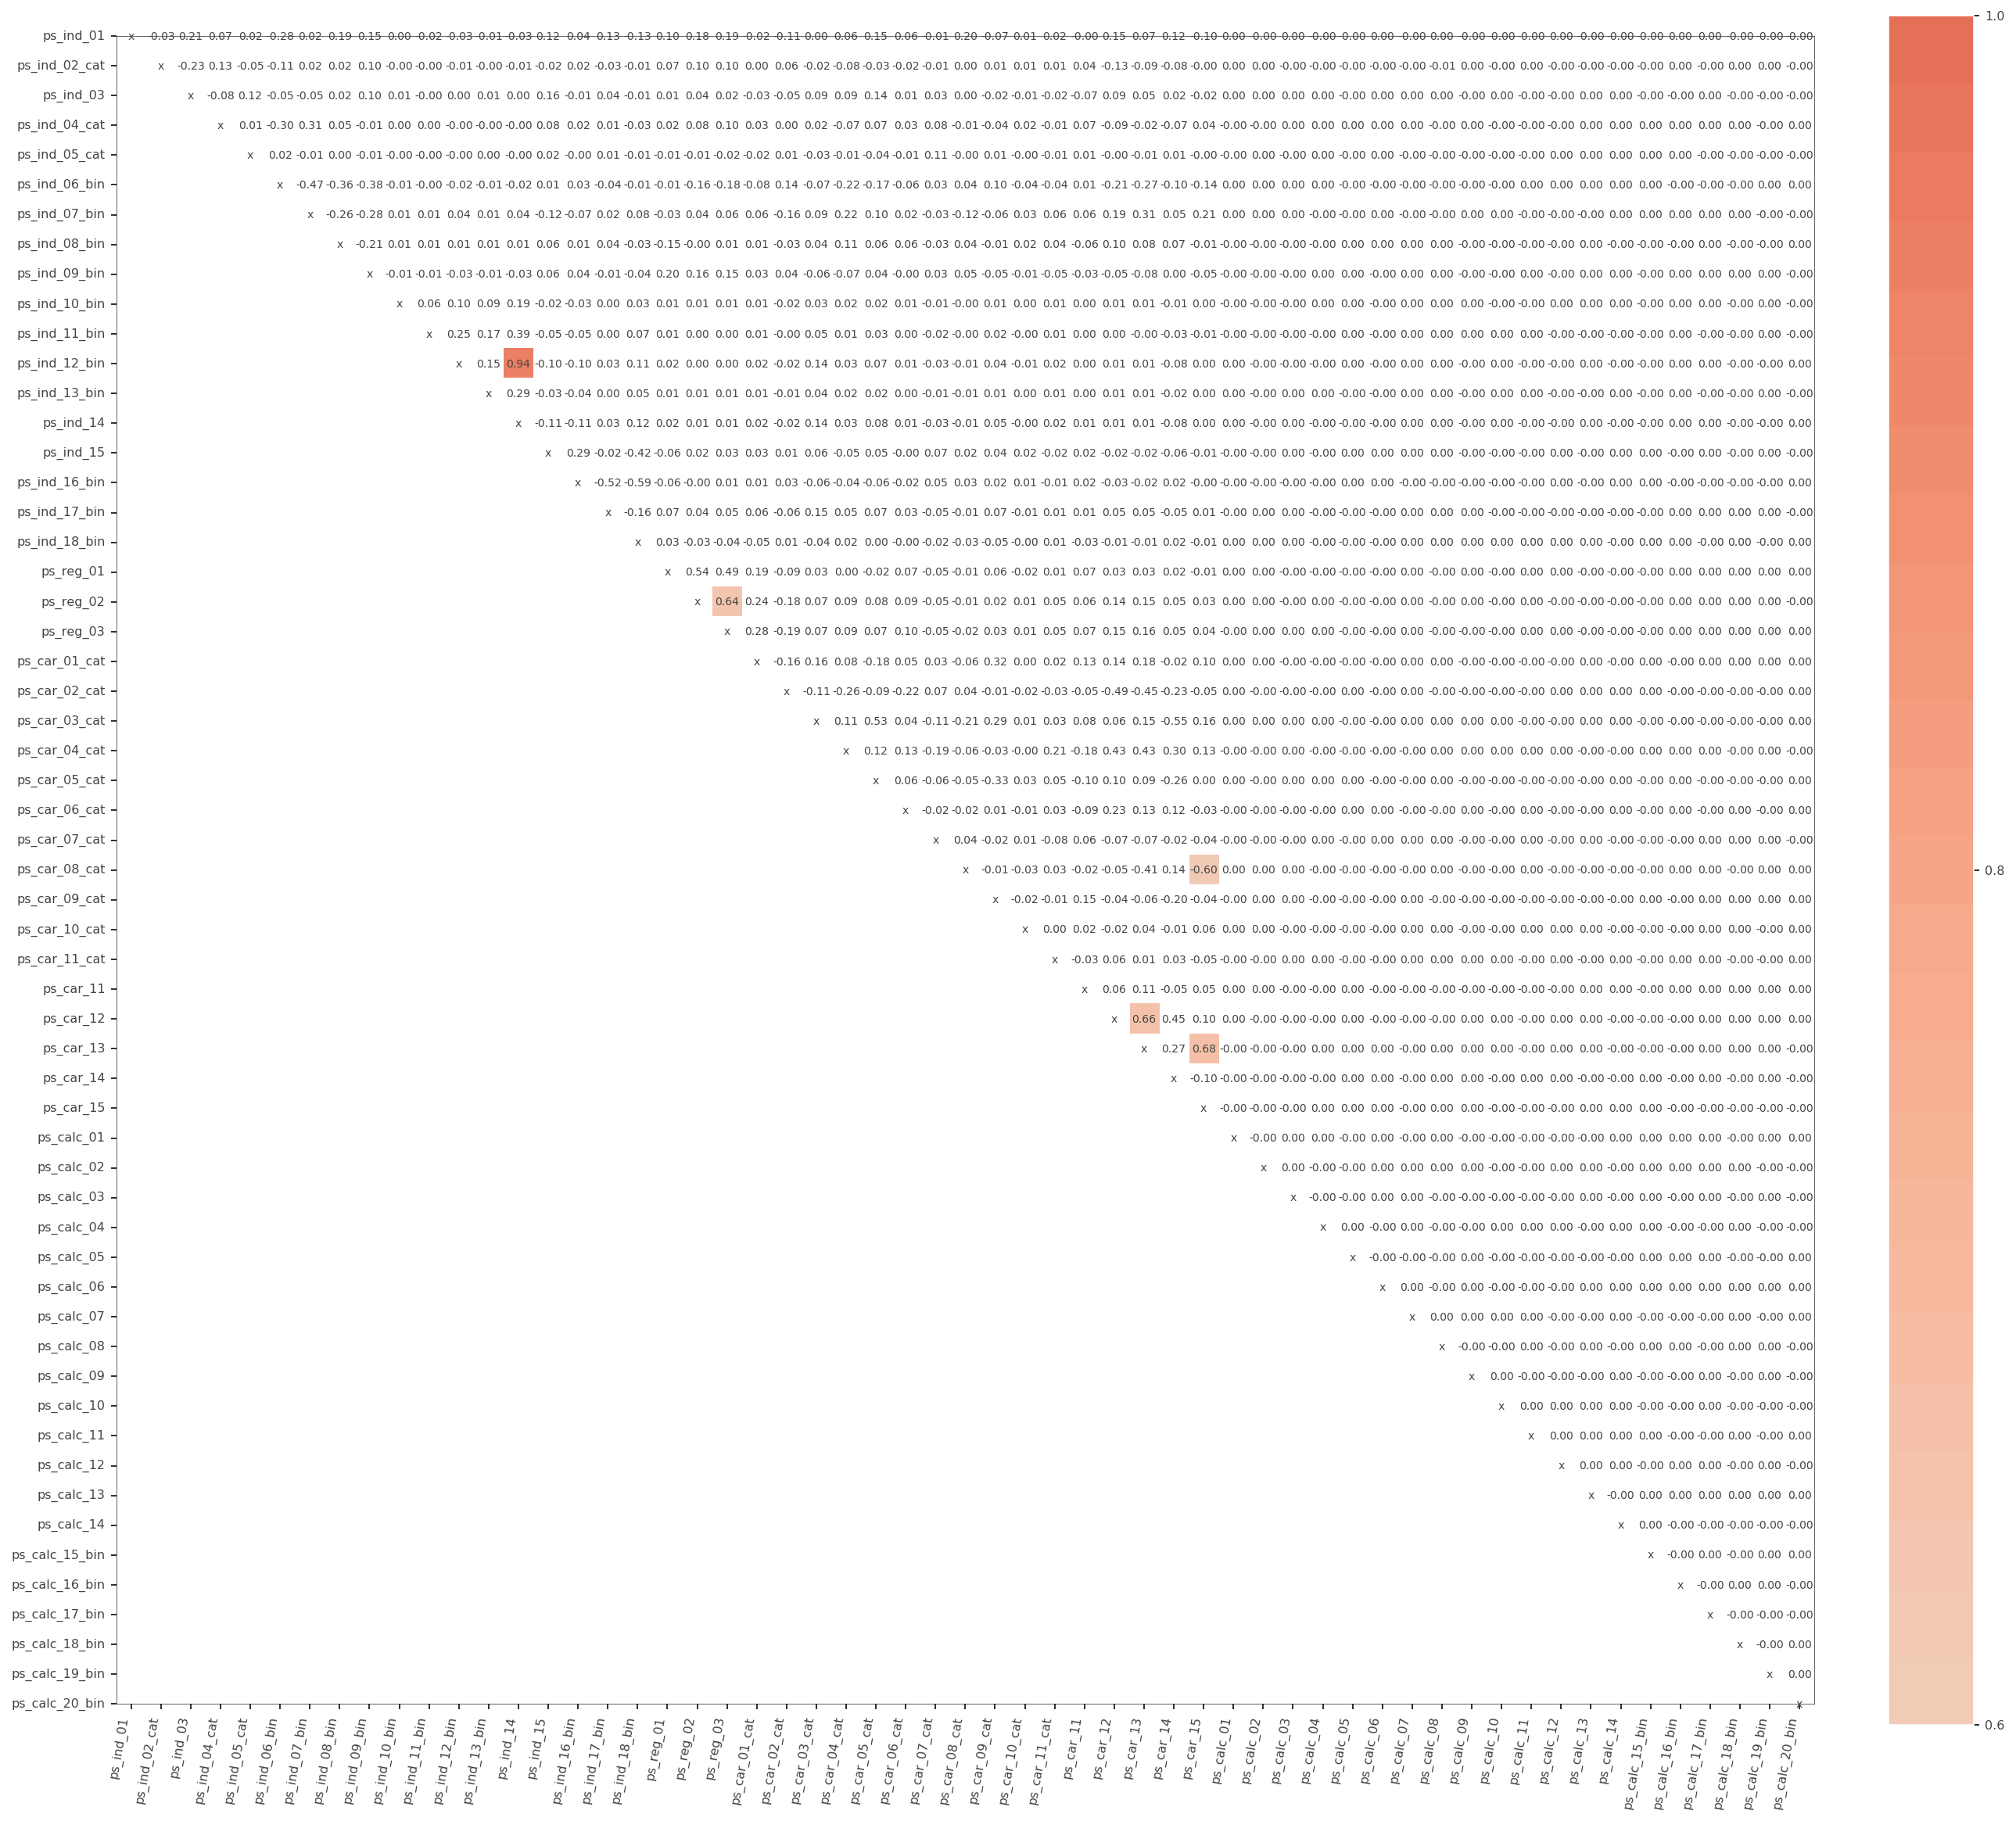

In [20]:
# выводим матрицу корреляций (на основе 
# ранговой корреляции Спирмена)
viz2 = plot_corr_heatmap(X_train, 
                         figsize=(18, 18), 
                         label_fontsize=8, 
                         value_fontsize=7)
viz2.view()

In [21]:
# пишем функцию предварительной подготовки
def preprocessing(df, lightgbm=True, newdata=False):
    # удаляем столбцы с calc в названии
    calc_columns = df.columns[df.columns.str.contains('calc')]
    df.drop(calc_columns, axis=1, inplace=True)
    
    # для новых данных
    if newdata:
        # записываем id набора
        ident = df['id']
        # удаляем id из набора
        df.drop('id', axis=1, inplace=True)
        
    # для исторических данных
    else:
        # удаляем id из набора
        df.drop('id', axis=1, inplace=True)
        # формируем массив меток и массив признаков
        labels = df.pop('target')
        
    # если готовим данные для LightGBM
    if lightgbm:
        # удаляем наименее важные переменные
        some_columns = ['ps_ind_14', 'ps_car_10_cat',
                        'ps_ind_10_bin', 'ps_ind_11_bin',
                        'ps_ind_12_bin', 'ps_ind_13_bin', 
                        'ps_ind_18_bin']

        df.drop(some_columns, axis=1, inplace=True)
        
        # записываем список столбцов с cat в названии
        cat_columns = df.columns[df.columns.str.contains('cat')]

        # формируем массив с ними
        df_ = df[cat_columns]

        # столбцам с cat в названии присваиваем тип object
        # и выполняем дамми-кодирование
        for col in cat_columns:
            df[col] = df[col].astype('object')
    
        df = pd.get_dummies(df)

        # конкатенируем массив с исходными столбцами с cat в названии
        # и массив, к которому было применено дамми-кодирование
        df = pd.concat([df_, df], axis=1)
    
    # в противном случае (если готовим данные
    # для CatBoost и XGBoost)
    else:
        # удаляем наименее важные переменные
        some_columns = ['ps_ind_14', 'ps_car_10_cat', 
                        'ps_car_14', 'ps_ind_10_bin', 
                        'ps_ind_11_bin', 'ps_ind_12_bin', 
                        'ps_ind_13_bin', 'ps_car_11', 
                        'ps_car_12']
        df.drop(some_columns, axis=1, inplace=True)
    
    # для новых данных
    if newdata:
        # возвращаем преобразованный массив 
        # признаков, идентификатор
        return df, ident
    
    # для исторических данных
    else:
        # возвращаем преобразованный массив признаков,
        # массив меток
        return df, labels

In [22]:
# загружаем наборы
train = pd.read_csv('Data/porto_seguro_train.csv')
test = pd.read_csv('Data/porto_seguro_test.csv')

In [23]:
# выполняем предварительную подготовку
# данных для LightGBM
train, labels = preprocessing(train, 
                              lightgbm=True, 
                              newdata=False)
test, ident = preprocessing(test, 
                            lightgbm=True, 
                            newdata=True)

In [24]:
# создаем экземпляр класса LGBMClassifier
lightgbm_model = LGBMClassifier(random_state=42, 
                                feature_fraction=0.4, 
                                lambda_l1=8, 
                                bagging_fraction=0.1,
                                learning_rate=0.012, 
                                n_estimators=1600)

# строим модель на всей обучающей выборке
lightgbm_model.fit(train, labels)

# вычисляем вероятности для тестовой выборки
lgbm_preds_prob = lightgbm_model.predict_proba(test)[:, 1]

In [25]:
# загружаем наборы
train = pd.read_csv('Data/porto_seguro_train.csv')
test = pd.read_csv('Data/porto_seguro_test.csv')

In [26]:
# выполняем предварительную подготовку
# данных для CatBoost и XGBoost
train, labels = preprocessing(train, 
                              lightgbm=False, 
                              newdata=False)
test, ident = preprocessing(test, 
                            lightgbm=False, 
                            newdata=True)

In [27]:
# формируем массив индексов категориальных признаков
cat_features_ids = np.where(train.dtypes != float)[0]

# формируем обучающий пул
train_pool = Pool(train, 
                  labels, 
                  cat_features=cat_features_ids)

# создаем экземпляр класса CatBoostClassifier
catbst_model = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.1,
    random_strength=0.15,
    simple_ctr='Counter:CtrBorderCount=50',
    model_size_reg=0.1,
    max_depth=4,
    random_seed=0,
    logging_level='Silent')

# обучаем модель
catbst_model.fit(train_pool)

# вычисляем вероятности
catbst_preds_prob = catbst_model.predict_proba(test)[:, 1]

Change of simpleCtr will not affect combinations ctrs.


In [28]:
# создаем экземпляр класса XGBClassifier
xgbst_model = XGBClassifier(learning_rate=0.04,
                            subsample=0.7,
                            random_state=42,
                            max_depth=4,
                            n_estimators=500)

# обучаем модель
xgbst_model.fit(train, labels)

# вычисляем вероятности
xgbst_preds_prob = xgbst_model.predict_proba(test)[:, 1]

In [29]:
# усредняем вероятности с весами, 
# учитывающими качество модели
average_prob = (catbst_preds_prob * 0.5 + 
                xgbst_preds_prob * 0.3 + 
                lgbm_preds_prob * 1) / 3
# формируем посылку
pd.DataFrame({'id': ident, 'target': average_prob}).to_csv(
    'subm_seguro.csv', index=False)